# DATING APP REVIEW ANALYSIS
---

**Author:** Tyler Chang • **Data Source:** [Link]('https://www.kaggle.com/datasets/sidharthkriplani/datingappreviews') • **Current Version:** 1.0 • **Latest Update:** July 22, 2023

---

This report covers the analysis of over 600,000 reviews for Tinder, Bumble, and Hinge between 2017--2022. While each of the apps has seen its respective user-base grow in size over time, there has been a widespread decline in the review ratings of all three recently. 

### LOADING ALL REQUIRED PACKAGES AND LIBRARIES

In [24]:
# data manipulation
import pandas as pd
import numpy as np
import string
from datetime import datetime
import re

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from textblob import Word, TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

# miscellaneous
import time
import pickle

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import ensemble, naive_bayes
from sklearn.metrics import f1_score, accuracy_score

Due to the size of the raw data file, it has been downloaded and loaded locally. 

In [5]:
### Loading the dataset
df = pd.read_csv('DatingAppReviewsDataset.csv')

### DATA CLEANING

In [6]:
### Looking at the first 5 rows of the raw table
df.head(5)

,Unnamed: 0,Name,Review,Rating,#ThumbsUp,Date&Time,App
0,0,linah sibanda,On this app i cant find a partner,5,0,18-02-2022 01:19,Tinder
1,1,Norman Johnson,Tinder would be so much better if we could spe...,3,0,18-02-2022 01:16,Tinder
2,2,David Hume,Still doesn't correctly notify matches or mess...,1,0,18-02-2022 01:11,Tinder
3,3,Last 1 Standing,"Got banned because I updated my bio to say ""I ...",2,0,18-02-2022 01:11,Tinder
4,4,Arthur Magamedov,Love it!,5,0,18-02-2022 01:06,Tinder


The first two columns--*Unnamed:0* and *Name*--are unneeded and can be removed.

In [7]:
df.drop(columns = ['Unnamed: 0', 'Name'], inplace = True)

In [8]:
### dimensions of the table
df.shape

(681994, 5)

There are 681,994 rows of data and 5 columns. The columns are as follows:

* *Review*: Text reviews that accompanied a user's numeric rating of the app.
* *Rating*: Numeric score a user gave the app during the review process.
* *#ThumbsUp*: Number of other users who marked a review as helpful.
* *Date&Time*: Records the day, month, year, and time of the review being submitted.
* *App*: Indicates which app is being reviewed.

In [9]:
### overview of the current table
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681994 entries, 0 to 681993
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Review     680609 non-null  object
 1   Rating     681994 non-null  int64 
 2   #ThumbsUp  681994 non-null  int64 
 3   Date&Time  681994 non-null  object
 4   App        681994 non-null  object
dtypes: int64(2), object(3)
memory usage: 26.0+ MB


The Review column is the only one missing values. 

In [10]:
### number of missing values in the review column
df.Review.isna().sum()

1385

Since there are only 1,352 missing reviews (roughly 0.1% of the overall data), I am going to drop them. While the numeric scores are available, the minimal percentage of the data being lost is unlikely to make a nontrivial impact on the overall analysis.

In [11]:
### dropping the rows with no text review
df.drop(df[df.Review.isna()].index, inplace = True)

We can now start cleaning up the review texts. To do this, I have built a function that makes all sentences lowercase, removes all numbers and punctuation, and strips off the excess whitespace.

In [12]:
### base text cleaning function
def bas_txt_clean(sentence):
    # Making the entire sentence lowercase
    sentence = sentence.lower()
    # Removing the numbers 
    sentence = ''.join(char for char in sentence if not char.isdigit())
    # Removing punctuation
    for punctuation in string.punctuation:
        sentence = sentence.replace(punctuation, '')
    # Removing whitespace
    sentence = sentence.strip()
    # Returning the cleaned text
    return sentence

### applying the function to the reviews and adding a new column
df['cleaned_reviews'] = [bas_txt_clean(sentence) for sentence in df['Review']]

### dropping the original review column
df.drop(columns = 'Review', inplace = True)

The Date&Time column is currently a string and needs to be converted to a date-time format.

In [13]:
### converting the Date&Time column to correct format and adding to table as new column
df['Time'] = [datetime.strptime(dt, "%d-%m-%Y %H:%M") for dt in df['Date&Time']]

### removing the original Date&Time column
df.drop(columns='Date&Time', inplace=True)

Since the review scores are supposed to be between 1 and 5 (inclusive), I will check that all ratings are within that range.

In [14]:
df.Rating.value_counts()

Rating
1    251842
5    232732
4     86958
3     56850
2     52226
0         1
Name: count, dtype: int64

There is a single review that has a rating of 0, which can now be dropped.

In [15]:
df.drop(df[df.Rating == 0].index, inplace = True)

Finally, instead of just using numeric representations for the rating, I will create a new column that includes sentiment vocabulary.

In [16]:
# making a list of the sentiment labels
sent_label = []
for rev in df.Rating:
    if rev == 1:
        sent_label.append('Terrible')
    elif rev == 2:
        sent_label.append('Bad')
    elif rev == 3:
        sent_label.append('Neutral')
    elif rev == 4:
        sent_label.append('Good')
    else:
        sent_label.append('Excellent')

### adding the list to the table as a new column
df['Sentiment_Category'] = sent_label

### EDA

In [21]:
### number of reviews per app
pd.DataFrame(df.groupby('App')['Rating'].describe())[['count', 'mean', 'std']]

,count,mean,std
App,,,
Bumble,102376.0,2.832265,1.716081
Hinge,52990.0,3.180921,1.680777
Tinder,525242.0,3.007800,1.757112


Tinder, as the oldest app with the largest user-base, has the most reviews and accounts for approximately 77% of the data. Reviews of Bumble and Hinge make up approximately 15% and 8% of the data, respectively. 

The average ratings are fairly 

In [18]:
df.head(3)

,Rating,#ThumbsUp,App,cleaned_reviews,Time,Sentiment_Category
0,5,0,Tinder,on this app i cant find a partner,2022-02-18 01:19:00,Excellent
1,3,0,Tinder,tinder would be so much better if we could spe...,2022-02-18 01:16:00,Neutral
2,1,0,Tinder,still doesnt correctly notify matches or messa...,2022-02-18 01:11:00,Terrible


In [22]:
txt = df.cleaned_reviews.str.cat(sep = ' ')
font_path = "/System/Library/Fonts/Supplemental/Arial.ttf"
wordcloud = WordCloud(font_path= font_path, width=800, height=400, background_color="black").generate(txt)

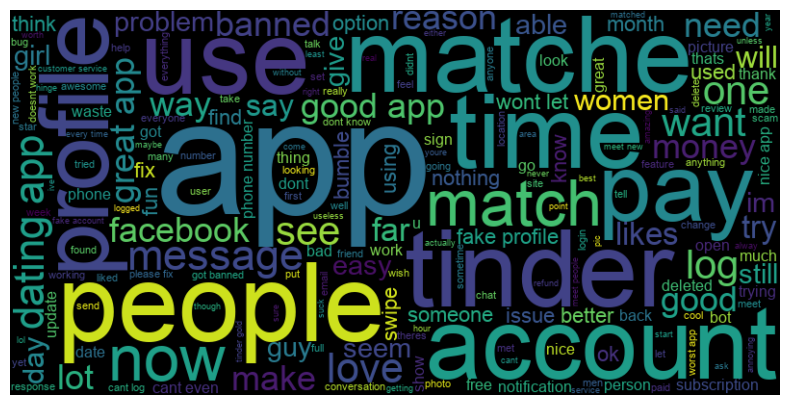

In [27]:
plt.figure(figsize=(40, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()